# Explore to define a threshold between same and unsame sample

In [1]:
import pickle
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/home/wangx/Downloads/facenet/src/')
import math
import facenet
import lfw

## Get embedding array and actual_issame

In [2]:
path_pairs = '/media/wangx/HDD1/yarn-dyed-fabric/pairs_fabrics.txt'
lfw_dir = '/media/wangx/HDD1/yarn-dyed-fabric/crop1600resize224/val'
model_dir = '/home/wangx/models/yarn-dyed-fabric/20171216-221842'
pairs = lfw.read_pairs(path_pairs)
paths, actual_issame = lfw.get_paths(lfw_dir, pairs, 'jpg')
actual_issame = np.asarray(actual_issame)

sess = tf.InteractiveSession()
facenet.load_model(model_dir)
# Get input and output tensors
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
image_size = 224
embedding_size = embeddings.get_shape()[1]
batch_size = 64
nrof_images = len(paths)
nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
emb_array = np.zeros((nrof_images, embedding_size))
for i in range(nrof_batches):
    start_index = i*batch_size
    end_index = min((i+1)*batch_size, nrof_images)
    paths_batch = paths[start_index:end_index]
    images = facenet.load_data(paths_batch, False, False, image_size)
    feed_dict = { images_placeholder:images, phase_train_placeholder:False }
    emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
sess.close()

Model directory: /home/wangx/models/yarn-dyed-fabric/20171216-221842
Metagraph file: model-20171216-221842.meta
Checkpoint file: model-20171216-221842.ckpt-80000
INFO:tensorflow:Restoring parameters from /home/wangx/models/yarn-dyed-fabric/20171216-221842/model-20171216-221842.ckpt-80000


KeyboardInterrupt: 

In [10]:
pickle.dump(emb_array, open('emb_array.pkl', 'wb'))
pickle.dump(actual_issame, open('actual_issame.pkl', 'wb'))

In [3]:
emb_array = pickle.load(open('emb_array.pkl', 'rb'))
actual_issame = pickle.load(open('actual_issame.pkl', 'rb'))

## Plot dist
Use distribution plot to get knowledge from data

In [4]:
from sklearn.model_selection import KFold
embeddings1 = emb_array[0::2]
embeddings2 = emb_array[1::2]
nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
nrof_folds = 10
k_fold = KFold(n_splits=nrof_folds, shuffle=False)
diff = np.subtract(embeddings1, embeddings2)
dist = np.sum(diff**2, 1)
actual_issame = np.asanyarray(actual_issame)

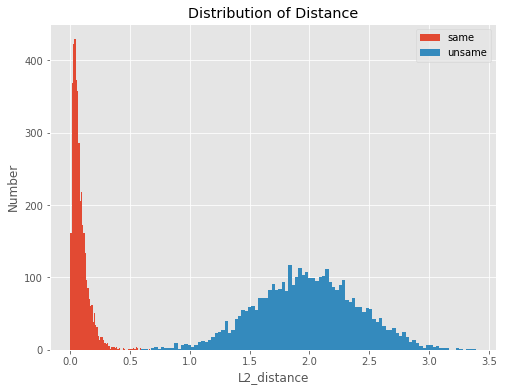

In [5]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(8, 6))
plt.hist(dist[actual_issame], bins=100, label='same')
plt.hist(dist[np.logical_not(actual_issame)], bins=100,
             label='unsame')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Number')
plt.savefig('dist.jpg')

In [6]:
print("Max dist of same pair: ", max(dist[actual_issame]))
print("Min dist of unsame pair: ", min(dist[np.logical_not(actual_issame)]))

Max dist of same pair:  1.0933965694
Min dist of unsame pair:  0.590451054213


## Explore threshold seperate pairs correctly

In [7]:
indices = np.arange(nrof_pairs)
train_set, test_set = next(k_fold.split(indices))
thresholds = np.arange(0, 3, 0.001)
nrof_thredholds = len(thresholds)
acc_train = np.zeros(nrof_thredholds)
for threshold_idx, threshold in enumerate(thresholds):
    _, _, acc_train[threshold_idx] = facenet.calculate_accuracy(threshold,
                                                                dist[train_set],
                                                                actual_issame[train_set])

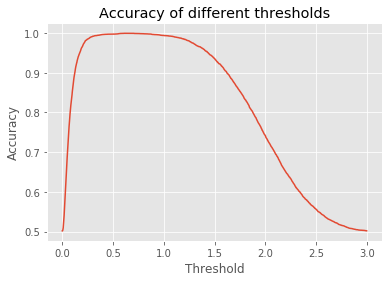

In [8]:
plt.plot(thresholds, acc_train, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

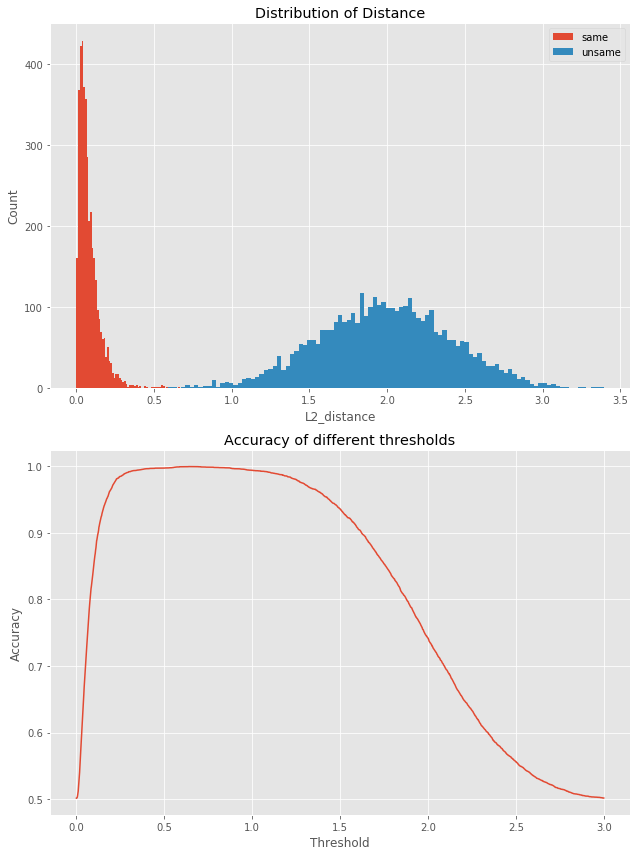

In [9]:
fig = plt.figure(figsize=(9, 12))
plt.subplot(211)
plt.hist(dist[actual_issame], bins=100, label='same')
plt.hist(dist[np.logical_not(actual_issame)], bins=100,
             label='unsame')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')

plt.subplot(212)
plt.plot(thresholds, acc_train, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('crop1600resize224.jpg')

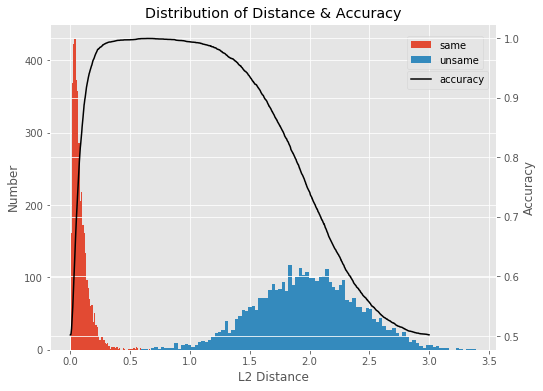

In [10]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.hist(dist[actual_issame], bins=100, label='same')
ax1.hist(dist[np.logical_not(actual_issame)], bins=100,
             label='unsame')
ax1.set_xlabel('L2 Distance')
ax1.set_ylabel('Number')

ax2 = ax1.twinx() # double axis
ax2.plot(thresholds, acc_train, label='accuracy', color='black')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Accuracy')
plt.title('Distribution of Distance & Accuracy')

legend1 = ax1.legend(loc=(.80, .86), fontsize=10)
legend2 = ax2.legend(loc=(.80, .80), fontsize=10)

In [11]:
tprs = np.zeros(nrof_thredholds)
fprs = np.zeros(nrof_thredholds)
for threshold_idx, threshold in enumerate(thresholds):
    tprs[threshold_idx], fprs[threshold_idx], _ = facenet.calculate_accuracy(threshold,
                                                                             dist[test_set],
                                                                             actual_issame[test_set])
    

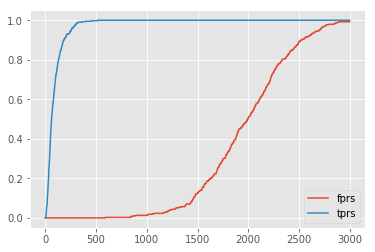

In [12]:
plt.plot(fprs, label='fprs')
plt.plot(tprs, label='tprs')
plt.legend()

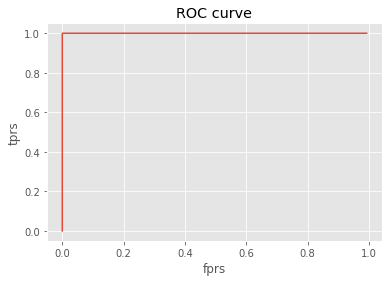

In [13]:
plt.plot(fprs, tprs)
plt.title('ROC curve')
plt.xlabel('fprs')
plt.ylabel('tprs')
plt.savefig('1600ROC.jpg')

In [16]:
# Back up for plot
dist1600 = dist
actual_issame1600 = actual_issame
acc_train1600 = acc_train

## Try with crop 224

In [17]:
tf.reset_default_graph()
path_pairs = '/media/wangx/HDD1/yarn-dyed-fabric/pairs_fabrics.txt'
lfw_dir = '/media/wangx/HDD1/yarn-dyed-fabric/crop224/val'
model_dir = '/home/wangx/models/yarn-dyed-fabric/20171229-233519'
pairs = lfw.read_pairs(path_pairs)
paths, actual_issame = lfw.get_paths(lfw_dir, pairs, 'jpg')
actual_issame = np.asarray(actual_issame)

sess = tf.InteractiveSession()
facenet.load_model(model_dir)
# Get input and output tensors
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
image_size = 224
embedding_size = embeddings.get_shape()[1]
batch_size = 64
nrof_images = len(paths)
nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
emb_array = np.zeros((nrof_images, embedding_size))
for i in range(nrof_batches):
    start_index = i*batch_size
    end_index = min((i+1)*batch_size, nrof_images)
    paths_batch = paths[start_index:end_index]
    images = facenet.load_data(paths_batch, False, False, image_size)
    feed_dict = { images_placeholder:images, phase_train_placeholder:False }
    emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
    print(i)
sess.close()

Model directory: /home/wangx/models/yarn-dyed-fabric/20171229-233519
Metagraph file: model-20171229-233519.meta
Checkpoint file: model-20171229-233519.ckpt-80000
INFO:tensorflow:Restoring parameters from /home/wangx/models/yarn-dyed-fabric/20171229-233519/model-20171229-233519.ckpt-80000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
2

In [18]:
from sklearn.model_selection import KFold
embeddings1 = emb_array[0::2]
embeddings2 = emb_array[1::2]
nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
nrof_folds = 10
k_fold = KFold(n_splits=nrof_folds, shuffle=False)
diff = np.subtract(embeddings1, embeddings2)
dist = np.sum(diff**2, 1)

In [19]:
indices = np.arange(nrof_pairs)
train_set, test_set = next(k_fold.split(indices))
thresholds = np.arange(0, 3, 0.001)
nrof_thredholds = len(thresholds)
acc_train = np.zeros(nrof_thredholds)
for threshold_idx, threshold in enumerate(thresholds):
    _, _, acc_train[threshold_idx] = facenet.calculate_accuracy(threshold,
                                                                dist[train_set],
                                                                actual_issame[train_set])

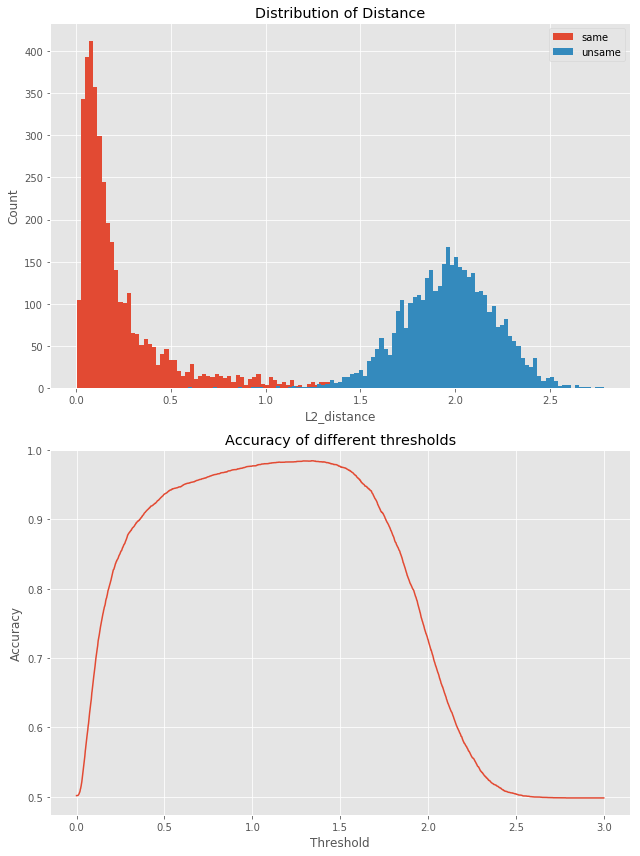

In [20]:
fig = plt.figure(figsize=(9, 12))
plt.subplot(211)
plt.hist(dist[actual_issame], bins=100, label='same')
plt.hist(dist[np.logical_not(actual_issame)], bins=100,
             label='unsame')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')
plt.savefig('dist.jpg')

plt.subplot(212)
plt.plot(thresholds, acc_train, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(ymax=1.)
plt.tight_layout()

In [21]:
tprs = np.zeros(nrof_thredholds)
fprs = np.zeros(nrof_thredholds)
for threshold_idx, threshold in enumerate(thresholds):
    tprs[threshold_idx], fprs[threshold_idx], _ = facenet.calculate_accuracy(threshold,
                                                                             dist[test_set],
                                                                             actual_issame[test_set])

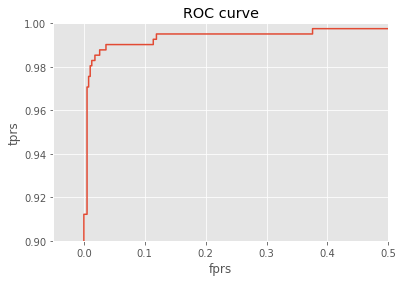

In [22]:
plt.plot(fprs, tprs)
plt.title('ROC curve')
plt.xlabel('fprs')
plt.ylabel('tprs')
plt.ylim(ymin=0.9, ymax=1.0)
plt.xlim(xmax=0.5)
plt.savefig('224ROC.jpg')

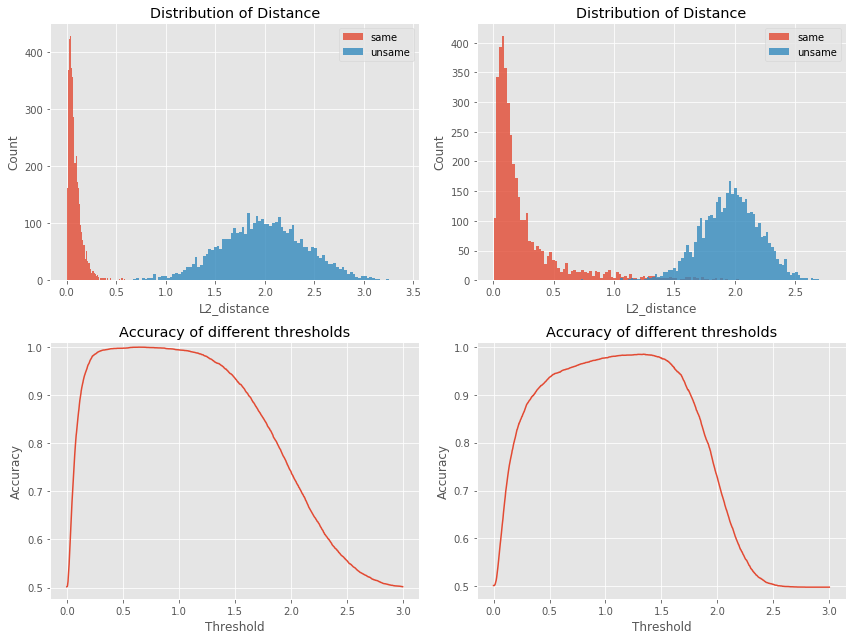

In [23]:
fig = plt.figure(figsize=(12, 9))
plt.subplot(221)
plt.hist(dist1600[actual_issame1600], bins=100, label='same', alpha=0.8)
plt.hist(dist1600[np.logical_not(actual_issame1600)], bins=100, alpha=0.8,
             label='unsame')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')

plt.subplot(223)
plt.plot(thresholds, acc_train1600, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(ymax=1.01)

plt.subplot(222)
plt.hist(dist[actual_issame], bins=100, label='same', alpha=0.8)
plt.hist(dist[np.logical_not(actual_issame)], bins=100, alpha=0.8,
             label='unsame')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')

plt.subplot(224)
plt.plot(thresholds, acc_train, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(ymax=1.01)

plt.tight_layout()
#plt.savefig('dist.jpg')

In [24]:
# Back up for plot
dist180 = dist
actual_issame180 = actual_issame
acc_train180 = acc_train

## Try squeezenet model

In [25]:
tf.reset_default_graph()
path_pairs = '/media/wangx/HDD1/yarn-dyed-fabric/pairs_fabrics.txt'
lfw_dir = '/media/wangx/HDD1/yarn-dyed-fabric/crop1600resize224/val'
model_dir = '/home/wangx/models/yarn-dyed-fabric/20171216-221842'
pairs = lfw.read_pairs(path_pairs)
paths, actual_issame = lfw.get_paths(lfw_dir, pairs, 'jpg')
actual_issame = np.asarray(actual_issame)

sess = tf.InteractiveSession()
facenet.load_model(model_dir)
# Get input and output tensors
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
image_size = 224
embedding_size = embeddings.get_shape()[1]
batch_size = 64
nrof_images = len(paths)
nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
emb_array = np.zeros((nrof_images, embedding_size))
for i in range(nrof_batches):
    start_index = i*batch_size
    end_index = min((i+1)*batch_size, nrof_images)
    paths_batch = paths[start_index:end_index]
    images = facenet.load_data(paths_batch, False, False, image_size)
    feed_dict = { images_placeholder:images, phase_train_placeholder:False }
    emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
    print(i)
sess.close()

Model directory: /home/wangx/models/yarn-dyed-fabric/20171216-221842
Metagraph file: model-20171216-221842.meta
Checkpoint file: model-20171216-221842.ckpt-80000
INFO:tensorflow:Restoring parameters from /home/wangx/models/yarn-dyed-fabric/20171216-221842/model-20171216-221842.ckpt-80000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
2

In [26]:
from sklearn.model_selection import KFold
embeddings1 = emb_array[0::2]
embeddings2 = emb_array[1::2]
nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
nrof_folds = 10
k_fold = KFold(n_splits=nrof_folds, shuffle=False)
diff = np.subtract(embeddings1, embeddings2)
dist = np.sum(diff**2, 1)

indices = np.arange(nrof_pairs)
train_set, test_set = next(k_fold.split(indices))
thresholds = np.arange(0, 3, 0.001)
nrof_thredholds = len(thresholds)
acc_train = np.zeros(nrof_thredholds)
for threshold_idx, threshold in enumerate(thresholds):
    _, _, acc_train[threshold_idx] = facenet.calculate_accuracy(threshold,
                                                                dist[train_set],
                                                                actual_issame[train_set])

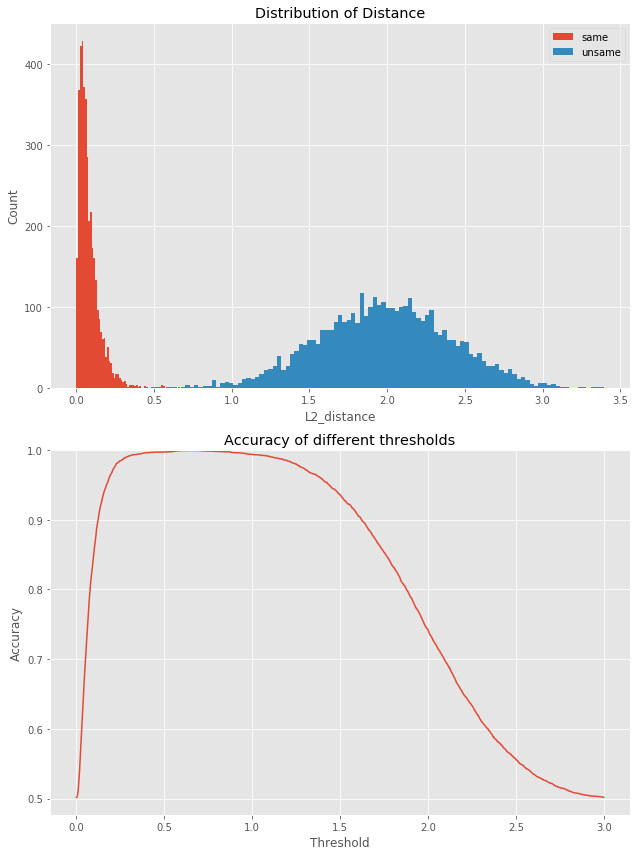

In [27]:
fig = plt.figure(figsize=(9, 12))
plt.subplot(211)
plt.hist(dist[actual_issame], bins=100, label='same')
plt.hist(dist[np.logical_not(actual_issame)], bins=100,
             label='unsame')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')
plt.savefig('dist.jpg')

plt.subplot(212)
plt.plot(thresholds, acc_train, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(ymax=1.)
plt.tight_layout()

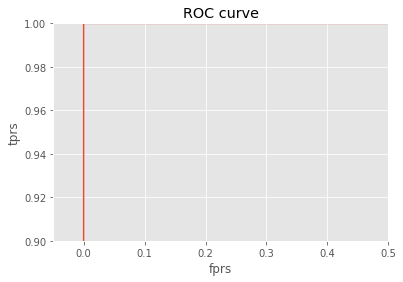

In [28]:
tprs = np.zeros(nrof_thredholds)
fprs = np.zeros(nrof_thredholds)
for threshold_idx, threshold in enumerate(thresholds):
    tprs[threshold_idx], fprs[threshold_idx], _ = facenet.calculate_accuracy(threshold,
                                                                             dist[test_set],
                                                                             actual_issame[test_set])
plt.plot(fprs, tprs)
plt.title('ROC curve')
plt.xlabel('fprs')
plt.ylabel('tprs')
plt.ylim(ymin=0.9, ymax=1.0)
plt.xlim(xmax=0.5)
plt.savefig('SqueezeROC.jpg')

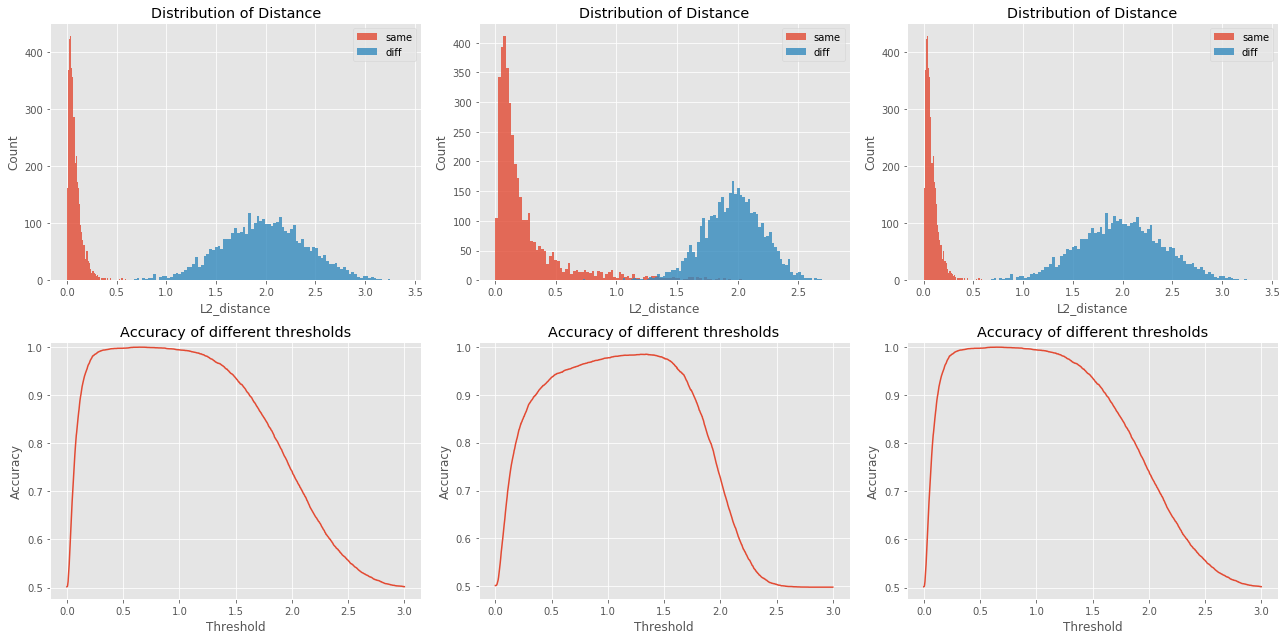

In [29]:
fig = plt.figure(figsize=(18, 9))
plt.subplot(231)
plt.hist(dist1600[actual_issame1600], bins=100, label='same', alpha=0.8)
plt.hist(dist1600[np.logical_not(actual_issame1600)], bins=100, alpha=0.8,
             label='diff')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')

plt.subplot(234)
plt.plot(thresholds, acc_train1600, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(ymax=1.01)

plt.subplot(232)
plt.hist(dist180[actual_issame180], bins=100, label='same', alpha=0.8)
plt.hist(dist180[np.logical_not(actual_issame180)], bins=100, alpha=0.8,
             label='diff')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')

plt.subplot(235)
plt.plot(thresholds, acc_train180, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(ymax=1.01)

plt.subplot(233)
plt.hist(dist[actual_issame], bins=100, label='same', alpha=0.8)
plt.hist(dist[np.logical_not(actual_issame)], bins=100, alpha=0.8,
             label='diff')
plt.title('Distribution of Distance')
plt.legend()
plt.xlabel('L2_distance')
plt.ylabel('Count')

plt.subplot(236)
plt.plot(thresholds, acc_train, label='Accuracy')
plt.title('Accuracy of different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(ymax=1.01)

plt.tight_layout()
plt.savefig('dist.jpg', dpi=96)